# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb


# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
quantities_api=Binance.binance_api.user_asset()
quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
quantities['asset']=quantities['asset']+'USDT'
quantities=quantities.set_index('asset')

In [7]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [8]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [9]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)

In [10]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*quantities['free'].astype(float))
pnl['Unrealized PnL']=pnl['Price in USDT']-pnl['Book Cost']
pnl=pnl.fillna(0)
pnl['Total']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.round(4).sort_values(by='Total')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total
Total,2184.9350,1944.2828,1.0000,-131.8862,-240.6522,-372.5384
JASMYUSDT,387.4585,236.9245,0.1219,0.0000,-150.5340,-150.5340
ETHUSDT,250.7473,167.2122,0.0860,0.0000,-83.5351,-83.5351
BBUSDT,60.1761,34.4114,0.0177,-39.7331,-25.7646,-65.4977
BTCUSDT,601.0216,539.4196,0.2774,3.5371,-61.6020,-58.0649
PEPEUSDT,0.0000,0.0000,0.0000,-38.5220,-0.0000,-38.5220
SOLUSDT,281.2005,249.9817,0.1286,0.0000,-31.2189,-31.2189
BNBUSDT,1.1421,0.9719,0.0005,-10.6060,-0.1702,-10.7762
NEARUSDT,0.0000,0.0000,0.0000,-10.3396,0.0000,-10.3396
TRXUSDT,76.8690,77.9534,0.0401,-10.7239,1.0844,-9.6395


In [11]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [12]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [13]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [14]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions

In [15]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [16]:
positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())

In [17]:
positions

,BBUSDT,BNBUSDT,BTCUSDT,ETHUSDT,JASMYUSDT,OMUSDT,PEPEUSDT,SOLUSDT,TRXUSDT
2024-09-10,36.041216,0.020742,586.319975,165.611259,257.009397,219.007443,0.000002,242.837798,297.241866
2024-09-11,33.596560,0.021268,583.288580,162.285194,255.346320,222.440487,0.000002,237.090475,297.824313
2024-09-12,34.946941,0.021845,591.369046,163.755818,257.137326,241.790376,0.000002,243.589784,295.106229
2024-09-13,38.264689,0.022323,615.434659,169.124532,270.058157,234.487353,0.000002,248.907400,289.281764
2024-09-14,38.730337,0.022198,610.297696,167.640734,262.510345,228.287067,0.000002,245.541367,286.369532
2024-09-15,36.506864,0.022202,601.538601,160.589920,252.276024,223.210322,0.000002,235.210510,289.281764
2024-09-16,37.729192,0.021412,592.199860,159.174072,245.495786,220.235016,0.000002,235.389554,289.087615
2024-09-17,40.523085,0.021914,613.562761,162.371864,252.531882,218.508091,0.000002,235.514885,291.223252
2024-09-18,41.629001,0.022447,546.624084,164.656497,260.335552,322.801671,0.000002,240.528126,290.446657
2024-09-19,41.535871,0.022748,557.138811,170.928663,270.058157,314.231467,0.000002,255.836415,294.135485


In [18]:
positions=positions.sort_index()

In [19]:
positions.index=pd.to_datetime(positions.index)

In [20]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [21]:
positions.to_excel('Positions.xlsx')
quantities.to_excel('Quantities.xlsx')

In [22]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [23]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [24]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [25]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [26]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [27]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [28]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

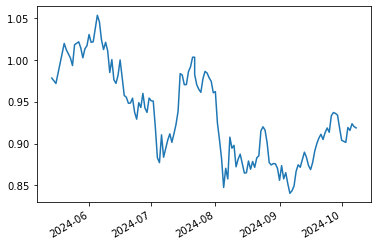

In [29]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [30]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [31]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [32]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT', 'BTCUSDT',
       'CFXUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT', 'EOSUSDT', 'ETCUSDT',
       'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT', 'FLOWUSDT',
       'FTMUSDT', 'FTTUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT',
       'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT', 'LTCUSDT',
       'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT', 'OPUSDT', 'ORDIUSDT',
       'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT',
       'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'UNIUSDT',
       'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT', 'XLMUSDT',
       'XRPUSDT'],
      dtype='object')

In [33]:
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

In [34]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit_hist[3]]-0.001}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
USDCUSDT,0.9422
OMUSDT,0.0203
TRXUSDT,0.0180
BNBUSDT,0.0149
PEPEUSDT,0.0040
SUIUSDT,0.0006
BONKUSDT,0.0000
LDOUSDT,0.0000
RUNEUSDT,0.0000
WLDUSDT,0.0000


In [35]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.499933
BTCUSDT,0.400000
PEPEUSDT,0.065012
BNBUSDT,0.035054


In [36]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [37]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
TRXUSDT,0.740946
OMUSDT,0.259054


## Real Portfolio vs Optimal

In [38]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,637.407990,0.327837,0.259054,0.068783
BTCUSDT,539.419638,0.277439,0.000000,0.000000
SOLUSDT,249.981666,0.128573,0.000000,0.000000
JASMYUSDT,236.924542,0.121857,0.000000,0.000000
ETHUSDT,167.212235,0.086002,0.000000,0.000000
TRXUSDT,77.953369,0.040094,0.740946,-0.700852
BBUSDT,34.411445,0.017699,0.000000,0.000000
BNBUSDT,0.971940,0.000500,0.000000,0.000000
PEPEUSDT,0.000002,0.000000,0.000000,0.000000


In [39]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,637.407990,0.327837,0.499933,-0.172096
BTCUSDT,539.419638,0.277439,0.400000,-0.122561
SOLUSDT,249.981666,0.128573,0.000000,0.000000
JASMYUSDT,236.924542,0.121857,0.000000,0.000000
ETHUSDT,167.212235,0.086002,0.000000,0.000000
TRXUSDT,77.953369,0.040094,0.000000,0.000000
BBUSDT,34.411445,0.017699,0.000000,0.000000
BNBUSDT,0.971940,0.000500,0.035054,-0.034554
PEPEUSDT,0.000002,0.000000,0.065012,-0.065012


# Risk Reward Analysis

In [40]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [41]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

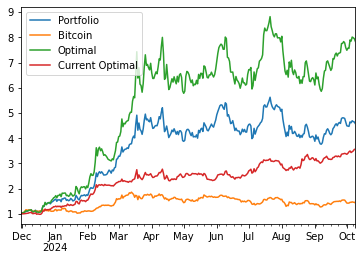

In [42]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [43]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

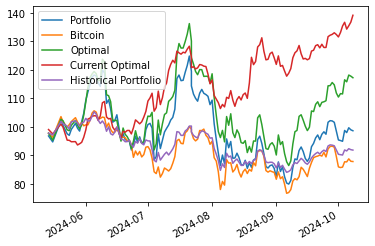

In [44]:
((1+current_perf.iloc[:]).cumprod()*100).plot()

In [45]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-09-29,101.612680,92.888537,114.744611,133.017951,93.379558
2024-09-30,98.435643,89.610942,111.882774,132.411696,91.840967
2024-10-01,95.421297,85.969490,110.468053,131.561488,90.386098
2024-10-02,95.214441,85.747939,111.673940,133.118707,90.261509
2024-10-03,94.952116,85.894047,111.562429,135.379562,90.135937
2024-10-04,98.750096,87.758707,116.518262,136.693852,91.907783
2024-10-05,98.004924,87.719120,115.811622,134.302157,91.567253
2024-10-06,99.698782,88.789524,118.184296,135.467128,92.355012
2024-10-07,98.978635,87.943245,117.797685,136.762575,92.014237
2024-10-08,98.647760,87.853439,117.249444,139.159025,91.863073


## Volatilities

In [46]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.736617
dtype: float64

In [47]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.536277
dtype: float64

In [48]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.611213
Bitcoin            0.437590
Optimal            0.737761
Current Optimal    0.415618
dtype: float64

In [49]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.20118282475029628

## Risk Contribution

In [50]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.040862,0.035054,0.006046,0.009574,0.000536,0.009037
BTCUSDT,0.174002,0.400000,0.045711,0.146284,0.056289,0.089995
OMUSDT,11.202972,0.499933,0.931961,0.793951,0.702258,0.091693
PEPEUSDT,0.139450,0.065012,0.016282,0.050192,0.012740,0.037452


In [51]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.152269,0.259054,0.308236,0.486099,0.423958,0.062141
TRXUSDT,0.182174,0.740946,0.691764,0.513901,0.451760,0.062141


In [52]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.192049,0.326733,0.472559,0.424031,0.254295,0.169736
BTCUSDT,-0.021358,0.277228,0.233072,0.176495,0.044162,0.132333
SOLUSDT,-0.021367,0.128713,0.097781,0.127529,0.024864,0.102665
JASMYUSDT,-0.026802,0.118812,0.083812,0.164400,0.045079,0.119322
ETHUSDT,-0.022117,0.089109,0.061023,0.068520,0.007934,0.060585
TRXUSDT,0.009737,0.039604,0.044945,0.006031,0.000487,0.005544
BBUSDT,-0.012328,0.019802,0.006809,0.032994,0.002641,0.030353


# Value At Risk

## Historical

In [53]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.06045465469058982, -0.08730406107398608)

In [54]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04931778884421499, -0.06821621541280566)

In [55]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [56]:
var=historical_var.iloc[row]
var

OMUSDT      -0.008810
BTCUSDT     -0.015511
SOLUSDT     -0.008753
JASMYUSDT   -0.005717
ETHUSDT     -0.007746
TRXUSDT     -0.000917
BBUSDT      -0.002198
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.049651
Name: 2024-08-27 00:00:00, dtype: float64

In [57]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.029832
BTCUSDT     -0.011697
SOLUSDT     -0.009425
JASMYUSDT   -0.009930
ETHUSDT     -0.005015
TRXUSDT     -0.000549
BBUSDT      -0.001768
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.068216
dtype: float64

## Parametric

In [58]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.0764438942402611, -0.09797993684981395)

In [59]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.0555668839530177, -0.07122138183523051)

## Multivariate

In [60]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.07035174850384618, -0.09015251283645265)

In [61]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05455698438437668, -0.06863288443111824)

In [62]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.022723
BTCUSDT     -0.009858
SOLUSDT     -0.007049
JASMYUSDT   -0.009018
ETHUSDT     -0.003556
TRXUSDT     -0.000355
BBUSDT      -0.001764
Portfolio   -0.054323
dtype: float64

## Copulas

### Gaussian Copula

In [63]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06914428098401415, -0.08896038546668748)

In [64]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.055125218783622795, -0.06808691726175363)

In [65]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.020522
BTCUSDT     -0.010263
SOLUSDT     -0.007602
JASMYUSDT   -0.009650
ETHUSDT     -0.004070
TRXUSDT     -0.000340
BBUSDT      -0.001766
Portfolio   -0.054213
dtype: float64

### Student Copula

In [66]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06768174453287178, -0.08725920200448103)

In [67]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.055161985489453, -0.07035846277675183)

In [68]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.021724
BTCUSDT     -0.010108
SOLUSDT     -0.007459
JASMYUSDT   -0.009480
ETHUSDT     -0.004135
TRXUSDT     -0.000342
BBUSDT      -0.002048
Portfolio   -0.055294
dtype: float64

### Gumbel Copula

In [69]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.1328417963228843, -0.19244340610415892)

In [70]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07186438717774683, -0.09817759096236733)

In [71]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.053990
BTCUSDT     -0.007619
SOLUSDT     -0.004703
JASMYUSDT   -0.004025
ETHUSDT     -0.001993
TRXUSDT      0.000269
BBUSDT       0.000049
Portfolio   -0.072013
dtype: float64

### Monte Carlo

In [72]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [73]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07797752176937768, -0.09837635686094495)

In [74]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05640804421358789, -0.07095073086700264)

In [75]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.022923
BTCUSDT     -0.009571
SOLUSDT     -0.007582
JASMYUSDT   -0.010122
ETHUSDT     -0.003934
TRXUSDT     -0.000337
BBUSDT      -0.002076
Portfolio   -0.056546
dtype: float64

## VaR Violation

In [76]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.061564,-0.111040,-0.091693,-0.024572
2024-01-15,-0.061564,-0.111035,-0.094354,0.016372
2024-01-16,-0.061564,-0.111754,-0.089641,0.062524
2024-01-17,-0.061564,-0.114192,-0.096377,-0.036487
2024-01-18,-0.061564,-0.116228,-0.098539,-0.034138
...,...,...,...,...
2024-10-05,-0.029599,-0.060202,-0.051951,-0.006065
2024-10-06,-0.023667,-0.057751,-0.047466,0.020487
2024-10-07,-0.023667,-0.056999,-0.044880,-0.003271
2024-10-08,-0.023667,-0.057248,-0.047403,-0.004654


In [77]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.031471,-0.084553,-0.079793,-0.016949
2024-05-29,-0.029229,-0.081742,-0.073630,-0.009967
2024-05-30,-0.029229,-0.070725,-0.066078,0.033433
2024-05-31,-0.029229,-0.070004,-0.063811,0.028696
2024-06-01,-0.029229,-0.071657,-0.063007,0.043670
...,...,...,...,...
2024-10-05,-0.031176,-0.049808,-0.047643,-0.007546
2024-10-06,-0.031176,-0.050429,-0.047416,0.017283
2024-10-07,-0.031176,-0.049332,-0.046445,-0.007223
2024-10-08,-0.031176,-0.048158,-0.046918,-0.003343


<AxesSubplot:>

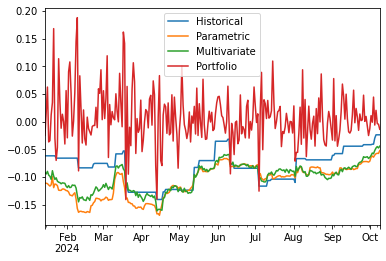

In [78]:
var_data.plot()

<AxesSubplot:>

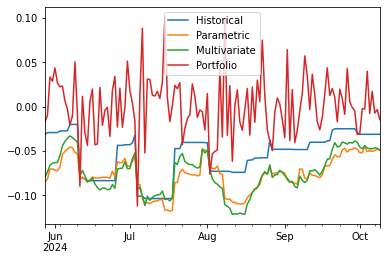

In [79]:
current_var_data.plot()

In [80]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.018519,0.011111,0.011111
Kupiec Stat,7.346098,12.399612,12.399612
P-value,0.006721,0.000429,0.000429


In [81]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.059259,0.022222,0.022222
Kupiec Stat,0.230608,2.743014,2.743014
P-value,0.631074,0.09768,0.09768


## Principal Component Analysis

### Historical PCA

In [82]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.7842088 , 0.0685019 , 0.05589273, 0.04745242, 0.04394414])

In [83]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.015010
ADAUSDT      0.015279
ALGOUSDT     0.016879
APTUSDT      0.016133
ARBUSDT      0.016657
               ...   
WBETHUSDT    0.012754
WBTCUSDT     0.010555
WLDUSDT      0.023087
XLMUSDT      0.010160
XRPUSDT      0.009781
Name: PC1, Length: 61, dtype: float64

<AxesSubplot:>

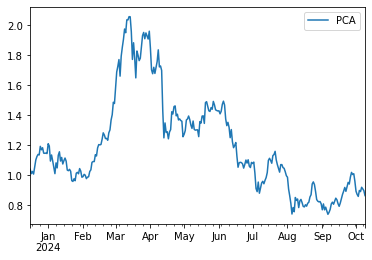

In [84]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

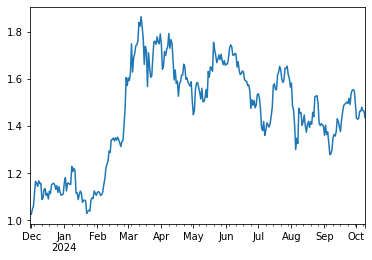

In [85]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [86]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
ADAUSDT      0.343075
ALGOUSDT     0.349759
WBETHUSDT    0.358910
ETHUSDT      0.358989
               ...   
PEPEUSDT     1.005024
FLOKIUSDT    1.011291
FTTUSDT      1.037558
WLDUSDT      1.050197
OMUSDT       1.320981
Length: 62, dtype: float64

<AxesSubplot:>

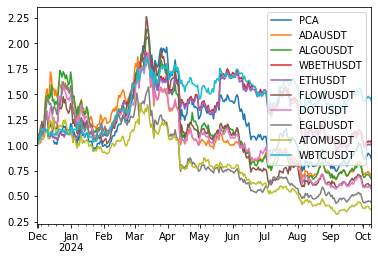

In [87]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

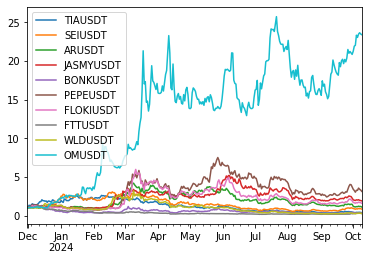

In [88]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

### Current PCA

In [89]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.67253891, 0.13787043, 0.08799103, 0.06978705, 0.03181258])

In [90]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.096092
BTCUSDT      0.064490
SOLUSDT      0.104534
JASMYUSDT    0.155229
ETHUSDT      0.086449
TRXUSDT      0.014722
BBUSDT       0.242855
BNBUSDT      0.068242
PEPEUSDT     0.167387
Name: PC1, dtype: float64

<AxesSubplot:>

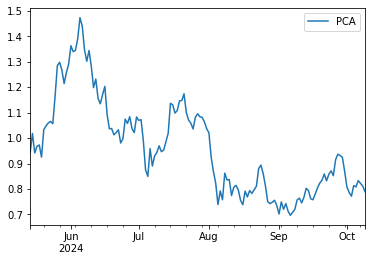

In [91]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

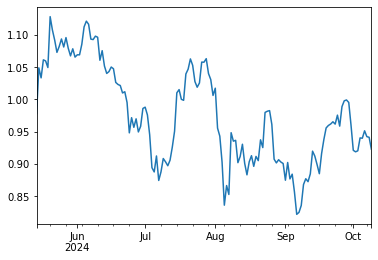

In [92]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [93]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
ETHUSDT      0.337502
SOLUSDT      0.345581
BTCUSDT      0.371670
BNBUSDT      0.374662
JASMYUSDT    0.428514
PEPEUSDT     0.479922
OMUSDT       0.555764
TRXUSDT      0.558430
BBUSDT       0.631943
dtype: float64

<AxesSubplot:>

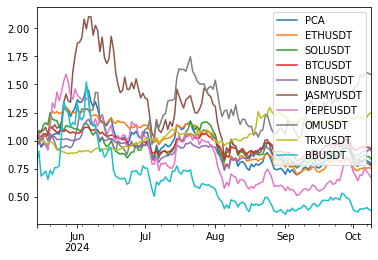

In [94]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [95]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.956403
BBUSDT       1.668584
JASMYUSDT    1.301121
SOLUSDT      1.170410
BTCUSDT      1.000000
OMUSDT       0.977215
ETHUSDT      0.956682
BNBUSDT      0.678641
TRXUSDT      0.277778
Name: BTCUSDT, dtype: float64

In [96]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     2.970152
BBUSDT       2.709006
JASMYUSDT    2.034880
SOLUSDT      1.405088
ETHUSDT      1.023664
BTCUSDT      1.000000
BNBUSDT      0.991846
OMUSDT       0.511992
TRXUSDT      0.303442
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [97]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.000000,0.622138,0.000000,0.000000,0.000000,0.000000,0.377862
2024-06-10,0.625881,0.000000,0.000000,0.150844,0.000000,0.223275,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182521,0.000000,0.000000,0.000000,0.000000,0.817479,0.000000,0.000000,0.000000
2024-07-22,0.133222,0.414537,0.111977,0.000000,0.000000,0.340265,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926695,0.000000,0.073305,0.000000
2024-09-02,0.435173,0.000000,0.000000,0.000000,0.000000,0.564827,0.000000,0.000000,0.000000
2024-09-16,0.287486,0.000000,0.000000,0.000000,0.000000,0.000000,0.712514,0.000000,0.000000
2024-09-30,0.176594,0.000000,0.000000,0.000000,0.165826,0.527128,0.000000,0.000000,0.130451
